In [26]:
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.manifold import TSNE

In [5]:
subcorpora = ['archaic', 'classical', 'roman', 'christian', 'jewish']

religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [ ]:
# star dict dictionary
"https://github.com/Vuizur/Wiktionary-Dictionaries/blob/master/Ancient%20Greek-English%20Wiktionary%20dictionary%20stardict.tar.gz?raw=true"
#"https://github.com/Vuizur/Wiktionary-Dictionaries/blob/master/Ancient%20Greek-English%20Wiktionary%20dictionary%20stardict.tar.gz"

In [51]:
#lsj = requests.get("https://raw.githubusercontent.com/perseids-project/lsj-js/master/src/dictionaries/dictionary.json").json()
#lsj["θεός"]

In [6]:
vectors_seed1_dict = {}
vectors_seed2_dict = {}
for sub in subcorpora:
    vectors_seed1 = KeyedVectors.load("../data/large_data/vectors_{}_seed1.kv".format(sub))
    vectors_seed1_dict[sub] = vectors_seed1
    vectors_seed2 = KeyedVectors.load("../data/large_data/vectors_{}_seed2.kv".format(sub))
    vectors_seed2_dict[sub] = vectors_seed2

In [7]:
vectors_seed1_dict["archaic"]["ἀγαθός"]

array([ 1.524826  , -0.4050309 , -0.8123989 , -1.229036  ,  0.47232363,
       -1.2184308 ,  1.2349117 , -0.58043176, -1.5812721 ,  0.40092328,
       -0.23443414, -0.7422254 , -1.6245396 , -0.11819018, -0.8666356 ,
       -0.31406757, -0.11347961,  0.81643087,  0.01617606, -0.2674281 ,
       -0.23681837, -1.7048237 ,  0.6645272 , -1.3287183 , -0.30883557,
       -0.6528886 ,  1.3756114 , -1.0039988 , -0.3911665 ,  0.5781188 ,
       -0.762231  ,  0.340836  ,  0.42102823, -0.755939  , -1.8750805 ,
       -2.212931  ,  0.57479507, -1.1919935 , -1.6228495 ,  1.2022885 ,
       -0.6097263 , -0.13649613,  0.88312954,  0.01831929,  0.7746038 ,
       -0.04007259,  1.1371372 ,  1.4587787 , -0.27853736, -0.0580341 ,
       -0.41654924,  1.3935888 ,  0.75251436,  1.1960874 ,  1.0364802 ,
       -0.7729692 , -0.39878   , -0.02832877, -0.6144726 , -0.68392473,
       -0.69778067, -0.63134027, -0.29135162,  1.3023754 ,  0.28626293,
        1.0659131 , -0.8471497 ,  0.8646592 , -0.7661484 ,  1.40

In [8]:
n = 20
dfs = {}
for sub in subcorpora:
    sub_data = {}
    for key in religion_final + morality_final:
        neighbors_tups = vectors_seed2_dict[sub].most_similar(key, topn=n)
        tups_formatted = [tup[0] + " ({})".format(str(np.round(tup[1], 2))) for tup in neighbors_tups]
        sub_data[sub + " " + key] =  tups_formatted
    sub_data_df = pd.DataFrame(sub_data)
    dfs[sub] = sub_data_df


In [9]:
dfs["archaic"]

,archaic θεός,archaic Ζεύς,archaic εὐσεβής,archaic ἱερός,archaic ἀγαθός,archaic ἀρετή,archaic δίκαιος,archaic τιμή
0,Ζεύς (0.48),θεός (0.48),Σαλαμίς (0.33),ἑκατόμβη (0.3),φίλος (0.34),ἆθλον (0.3),ἁμαρτία (0.35),θεός (0.37)
1,ἀθάνατος (0.41),πᾶς (0.33),προφήτης (0.32),τελήεις (0.28),οἶος (0.33),ὄλβος (0.28),τις (0.32),γέρας (0.35)
2,εἰμί (0.39),ἀθάνατος (0.33),πλεονέκτης (0.32),ἱερόν (0.27),πολύς (0.32),νίκη (0.27),οὐδείς (0.31),ὄλβος (0.32)
3,τιμή (0.37),μάκαρ (0.31),Ὀλυμπιονίκης (0.3),πέμπω (0.26),ἀμύμων (0.32),νύσσα (0.26),κέρδος (0.31),Ὀλύμπιος (0.3)
4,κακός (0.37),εἰμί (0.31),εὐεργεσία (0.29),ἀράομαι (0.26),ἐύς (0.32),κίνδυνος (0.26),εὔκαιρος (0.3),νόος (0.3)
5,πᾶς (0.36),Ὀλύμπιος (0.31),διάνοια (0.28),πλέω (0.25),ἐσθλός (0.31),νεῖκος (0.26),μέμφομαι (0.3),ἄκοιτις (0.27)
6,Κρονίδης (0.35),μέγας (0.29),ἀρχή (0.28),εὔχομαι (0.25),εἰμί (0.31),γηρύω (0.26),συμφορά (0.3),ἀνήρ (0.27)
7,ξένος (0.34),σός (0.28),εὔδοξος (0.27),ἐρατεινός (0.25),βουληφόρος (0.3),Ἴσθμιος (0.25),κτέομαι (0.3),μάκαρ (0.27)
8,φίλος (0.34),Ἑρμῆς (0.27),εὐτελής (0.27),χῶρος (0.24),ἀνήρ (0.3),γενεά (0.25),πονηρός (0.3),δίδωμι (0.27)
9,μέγας (0.33),κῦδος (0.27),ἁβρός (0.27),ἡμέτερος (0.24),ἀριστεύς (0.3),ἄγαμαι (0.25),πράσσω (0.29),δῶρον (0.27)


In [10]:
dfs["classical"]

,classical θεός,classical Ζεύς,classical εὐσεβής,classical ἱερός,classical ἀγαθός,classical ἀρετή,classical δίκαιος,classical τιμή
0,δαίμων (0.52),Ἀσκληπιός (0.52),ὅσιος (0.49),τέμενος (0.59),σπουδαῖος (0.56),σωφροσύνη (0.57),ἀδικέω (0.54),τιμάω (0.5)
1,εὐσεβής (0.45),Ἥρα (0.5),ἀνόσιος (0.46),ἱερόν (0.56),ἀρετή (0.53),ἀνδρεία (0.54),οὗτος (0.47),φιλοτιμία (0.45)
2,δαιμόνιον (0.42),μῆτις (0.49),στυγέω (0.45),βωμός (0.54),ὠφέλιμος (0.51),ἀγαθός (0.53),ἄδικος (0.47),γέρας (0.45)
3,Ἀπόλλων (0.42),Διόνυσος (0.49),θεός (0.45),Πύθιος (0.51),κακός (0.51),δικαιοσύνη (0.52),δημοτικός (0.47),ἀξία (0.44)
4,τελετή (0.42),Ποσειδῶν (0.48),θεοφιλής (0.44),ἄγαλμα (0.48),εὐδαιμονία (0.51),φρόνησις (0.5),εὔορκος (0.45),εὐεργεσία (0.44)
5,θεῖος (0.39),λίσσομαι (0.46),ἀσεβέω (0.43),Ἄρτεμις (0.47),ἐπιεικής (0.49),ἐπαινετός (0.49),πράσσω (0.45),ἔπαινος (0.43)
6,ἵλαος (0.39),Ἀφροδίτη (0.46),εὐσέβεια (0.42),Ἀθήνη (0.47),χρηστός (0.49),κτῆσις (0.47),ἀγαθός (0.45),δωρεά (0.42)
7,ὅσιος (0.38),Ἥφαιστος (0.45),ἀσεβής (0.42),θύω (0.45),καλός (0.49),σπουδαῖος (0.47),νόμος (0.45),κτῆσις (0.41)
8,εὐχή (0.38),θεά (0.45),σεμνός (0.39),Ἀμφικτύονες (0.44),εὐδαίμων (0.47),εὐδαιμονία (0.46),πολίτης (0.44),προσήκω (0.41)
9,θεά (0.37),Ἀπόλλων (0.45),τελετή (0.39),Ἐλευσίνιος (0.44),φρόνιμος (0.47),καρτερία (0.46),προσήκω (0.43),κτῆμα (0.41)


In [11]:
dfs["roman"]

,roman θεός,roman Ζεύς,roman εὐσεβής,roman ἱερός,roman ἀγαθός,roman ἀρετή,roman δίκαιος,roman τιμή
0,θεῖος (0.59),Ἥφαιστος (0.53),ὅσιος (0.64),τέμενος (0.67),σπουδαῖος (0.56),ἀνδρεία (0.62),εὐσεβής (0.57),εὐεργετέω (0.61)
1,εὐχή (0.59),Ἀπόλλων (0.52),σωτήρ (0.58),ναός (0.65),φρόνιμος (0.55),σωφροσύνη (0.58),ὅσιος (0.54),δωρεά (0.59)
2,Ἀπόλλων (0.56),θεά (0.52),δίκαιος (0.57),ἱερόν (0.64),αἱρετός (0.54),ἐγκράτεια (0.58),ἄδικος (0.54),εὐεργεσία (0.58)
3,δαίμων (0.53),Λητώ (0.52),νομοθέτης (0.56),βωμός (0.61),φευκτός (0.52),δικαιοσύνη (0.58),κριτής (0.53),φιλανθρωπία (0.58)
4,τελετή (0.53),Ῥέα (0.52),σώφρων (0.53),ξόανον (0.6),ἐπαινετός (0.49),εὐδαιμονία (0.57),δικαιοσύνη (0.53),εὐεργέτης (0.57)
5,σωτήρ (0.52),Ποσειδῶν (0.51),ἀσεβής (0.52),Ἀθήνη (0.6),κακός (0.48),ἐπαινετός (0.56),πολιτεύω (0.53),τιμάω (0.57)
6,εὔχομαι (0.52),Ἀθήνη (0.51),φρόνιμος (0.51),Ἐλευσίς (0.57),βέλτιστος (0.48),αἱρετός (0.51),εὐεργέτης (0.52),γέρας (0.56)
7,θεά (0.51),Τιτάν (0.49),εὐσέβεια (0.51),Ἄρτεμις (0.57),δίκαιος (0.47),σύνεσις (0.5),μεγαλόψυχος (0.52),ἔπαινος (0.54)
8,μαντικός (0.51),θεός (0.49),θεός (0.5),καθιερόω (0.57),δικαιοσύνη (0.46),μεγαλοψυχία (0.5),νομοθέτης (0.52),εὔνοια (0.53)
9,ἀθάνατος (0.5),Ἑρμῆς (0.49),μακάριος (0.5),ἐπίκλησις (0.56),βελτίων (0.44),εὐγένεια (0.5),ἀδικέω (0.52),ἱερωσύνη (0.52)


In [12]:
dfs["christian"]

,christian θεός,christian Ζεύς,christian εὐσεβής,christian ἱερός,christian ἀγαθός,christian ἀρετή,christian δίκαιος,christian τιμή
0,πατήρ (0.68),ποιητής (0.37),ζηλωτής (0.32),θεῖος (0.35),κακός (0.42),θεωρητικός (0.42),δικαιοσύνη (0.42),χρεία (0.32)
1,πᾶς (0.61),ἄγνωστος (0.32),θεοσεβής (0.32),ἱστορία (0.35),καλός (0.41),στερέω (0.36),ἄδικος (0.39),κρατύς (0.28)
2,ἄνθρωπος (0.58),βαρούχ (0.3),Ἐπίκουρος (0.3),ἀλληγορία (0.33),θεός (0.36),σωφροσύνη (0.36),ἁμαρτάνω (0.35),χρυσός (0.28)
3,αὐτός (0.57),γεννάω (0.3),βοηθός (0.29),Ἀμβρόσιος (0.32),ἀρετή (0.36),ἀγαθός (0.36),θεός (0.34),τιμάω (0.27)
4,θεάομαι (0.55),οὗτος (0.26),φαῦλος (0.29),ἰδιωτικός (0.31),χρηστός (0.35),ἀπάθεια (0.35),ἔργον (0.33),ἄργυρος (0.26)
5,κύριος (0.54),ἐπιμιμνήσκομαι (0.26),ἀρνούμενος (0.29),ὑπαγορεύω (0.31),φαῦλος (0.33),πρακτικός (0.35),κρίσις (0.33),λογικοῦ (0.26)
6,υἱός (0.53),ποίησις (0.25),ἐπαινέω (0.29),πάνσοφος (0.31),πᾶς (0.33),ἀνδρεία (0.34),κύριος (0.33),καταφρονέω (0.25)
7,Χριστός (0.5),ὁμολογέω (0.25),ἀπατεών (0.29),σεμνός (0.31),ἄνθρωπος (0.32),ἐπιστήμη (0.31),δικαιόω (0.31),εὐάρεστος (0.25)
8,ποιέω (0.48),μόνος (0.25),εὐσεβέω (0.28),Ἀριστέας (0.29),πονηρός (0.3),θεωρία (0.3),θεοσεβής (0.31),ἄμετρος (0.24)
9,εἰμί (0.48),ὁμοιότης (0.24),ἀποστρέφω (0.27),νουθετέω (0.29),εὐάρεστος (0.3),βιόω (0.3),χρηστός (0.31),λειτουργία (0.24)


In [13]:
dfs["jewish"]

,jewish θεός,jewish Ζεύς,jewish εὐσεβής,jewish ἱερός,jewish ἀγαθός,jewish ἀρετή,jewish δίκαιος,jewish τιμή
0,κύριος (0.5),ὁσιότης (0.34),δίκαιος (0.4),ἱερόν (0.56),καλός (0.47),φαῦλος (0.5),φιλάνθρωπος (0.43),ἀξίωμα (0.4)
1,εὐλογέω (0.46),ὑπερυψοῦτε (0.3),εὐσέβεια (0.38),ναός (0.41),ἀρετή (0.44),καλοκἀγαθία (0.5),ὅσιος (0.4),τιμάω (0.39)
2,λέγω (0.45),οὐράνιος (0.3),βραβεύω (0.37),τέμενος (0.4),εὐδαιμονία (0.41),ἀγαθός (0.44),εὐσεβής (0.4),δωρεά (0.38)
3,ὕψιστος (0.42),αἰνός (0.29),ἐνθυμέομαι (0.35),ἱερή (0.39),μακάριος (0.39),εὐσέβεια (0.42),ἀγαθός (0.36),ἀξία (0.38)
4,εὐλογητός (0.4),ἀγέννητος (0.29),ἀγαθός (0.35),δημόσιος (0.37),θεός (0.39),ἀστεῖος (0.41),ἐπιεικής (0.35),πατρῷος (0.38)
5,ἀγαθός (0.39),θέω (0.29),εὐδοκία (0.34),χάλκεος (0.34),ἀστεῖος (0.39),σωφροσύνη (0.41),ἀλήθεια (0.35),προσηγορία (0.38)
6,ἐξομολογέομαι (0.39),γεν (0.28),ἀγεννήτου (0.33),Καπετώλιον (0.33),εὐνομία (0.38),ἐπίληπτος (0.41),δικαιοσύνη (0.35),ἀρχιερωσύνη (0.36)
7,ἄνθρωπος (0.38),μωαβ (0.27),ἀσεβής (0.33),ἄκρα (0.33),χρηστός (0.36),ἀίδιος (0.4),ἄδικος (0.34),θεραπεία (0.36)
8,Παντοκράτωρ (0.37),υπ (0.27),εὐσεβέω (0.32),συλάω (0.33),κρείσσων (0.36),εὐδαιμονία (0.4),μάρτυς (0.34),παραχωρέω (0.35)
9,σωτήρ (0.36),ἄσβεστος (0.27),ὅσιος (0.32),ἁγιστεία (0.32),δίκαιος (0.36),ἐγκράτεια (0.4),θεός (0.34),ἀμοιβή (0.35)


μάκαρ (0.31) μέγας (0.29) ἀθάνατος (0.33) ἀρχή (0.28)
εὔδοξος (0.27)


morality:
δικαιοσύνη
δικαιόω (0.31)
ἀδικέω (0.54)
ἄδικος (0.47)
σωφροσύνη (0.57)
φίλος (0.34)
ἁμαρτία (0.35) πονηρός (0.3) κακός (0.37)
τιμάω (0.5)
εὐεργετέω (to do well)
εὐεργεσία (well-doing)
εὐεργέτης (benefactor)
σπουδαῖος (good, in moral sense)
ἐπαινετός (laudable)
βέλτιστος (the best)
βελτίων (better)
μεγαλοψυχία (magnanimity)
μεγαλόψυχος (magnanimous)
τιμάω (to honour)
εὔνοια (good will)
καλός (beautiful, fair, right)
ἀλήθεια (truth)






religion:
ἵλαος (of gods),
εὐχή (prayer)
θεά,
θεῖος
εὐσέβεια
εὐσεβέω
εὐλογέω (0.46)
εὐλογητός (0.4)
θεοφιλής,
ἀσεβέω,
ἀσεβής, εὐσέβεια, θύω,
δαίμων (0.52) δαιμόνιον (0.42) τελετή (0.42) θεῖος (0.39)
ἱερόν (0.27) εὔχομαι (0.25)
ναός (0.65)
καθιερόω (devote, consecrate)
ἱερή (0.39)

Παντοκράτωρ
σωτήρ
οὐράνιος (0.3)
...deities..


In [65]:
morality_extension = ["δικαιοσύνη", "δικαιόω", "ἀδικέω", "ἄδικος", "σωφροσύνη", "φίλος", "ἁμαρτία", "πονηρός", "κακός", "τιμάω", "εὐεργετέω", "εὐεργεσία" "εὐεργέτης", "σπουδαῖος", "ἐπαινετός","βέλτιστος", "βελτίων", "μεγαλοψυχία", "μεγαλόψυχος", "τιμάω", "εὔνοια", "καλός", "ἀλήθεια"]
religion_extension = ["ἵλαος", "εὐχή", "θεά", "θεῖος", "εὐσέβεια", "εὐσεβέω", "εὐλογέω", "εὐλογητός", "θεοφιλής", "ἀσεβέω", "ἀσεβής", "εὐσέβεια", "θύω", "δαίμων", "δαιμόνιον", "τελετή", "θεῖος", "ἱερόν", "εὔχομαι", "ναός", "καθιερόω", "ἱερή"]

In [14]:
for worda in religion_final:
    for wordb in morality_final:
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=100)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda, wordb)
            print(sub, worda, wordb, pair_sim_score / topn_mean)

archaic θεός ἀγαθός -0.0003032685714591438
classical θεός ἀγαθός 0.7368091361056159
roman θεός ἀγαθός 0.6361474422872531
christian θεός ἀγαθός 1.0463762895233089
jewish θεός ἀγαθός 1.2053327037921113
archaic θεός ἀρετή 0.3151310274395954
classical θεός ἀρετή 0.802550278071436
roman θεός ἀρετή 0.5617484535507966
christian θεός ἀρετή 0.3743059520381188
jewish θεός ἀρετή 0.3450653312759259
archaic θεός δίκαιος 0.46488487395966527
classical θεός δίκαιος 0.8467846371333395
roman θεός δίκαιος 0.8342251583491739
christian θεός δίκαιος 1.0885412470452063
jewish θεός δίκαιος 1.2183840907681716
archaic θεός τιμή 1.184624458180033
classical θεός τιμή 0.8835647385770682
roman θεός τιμή 0.9872877131449672
christian θεός τιμή 0.3461636998924177
jewish θεός τιμή 0.29590282554574837
archaic Ζεύς ἀγαθός 0.4019744501856154
classical Ζεύς ἀγαθός -0.22373544017608732
roman Ζεύς ἀγαθός 0.0967793187388267
christian Ζεύς ἀγαθός 0.19972295303778653
jewish Ζεύς ἀγαθός -0.48784283244176285
archaic Ζεύς ἀρετή 0.

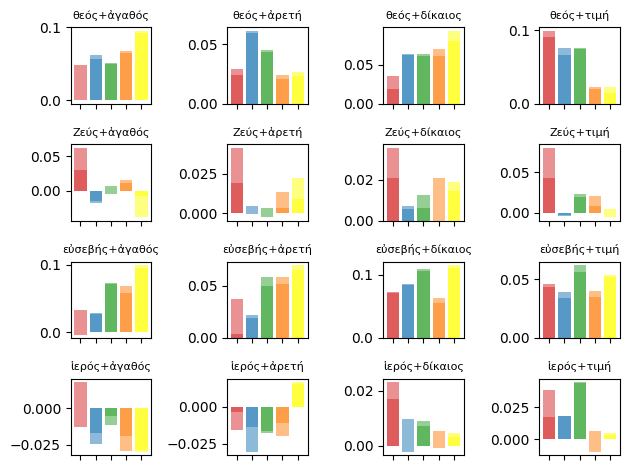

In [15]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

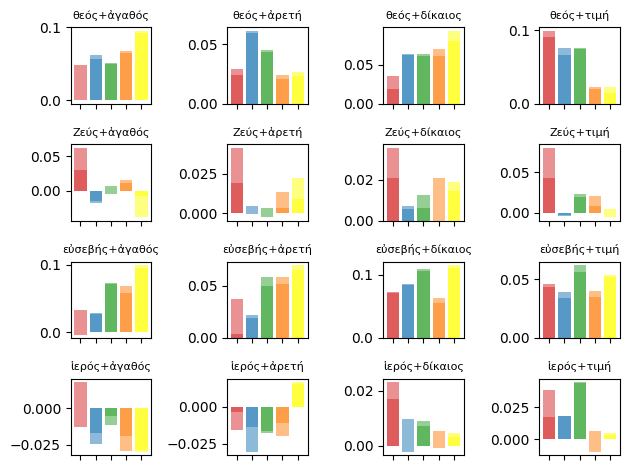

In [16]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

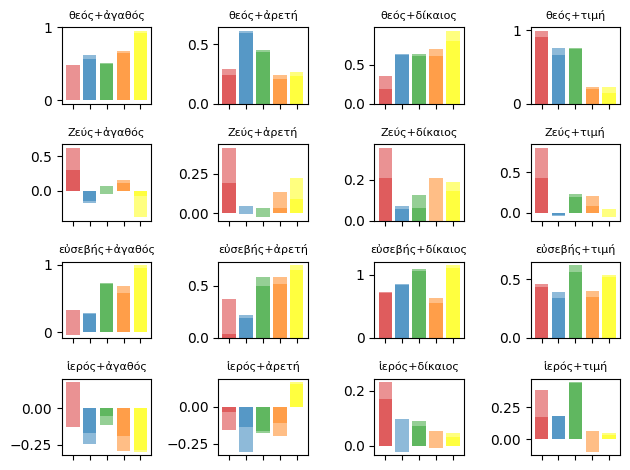

In [17]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

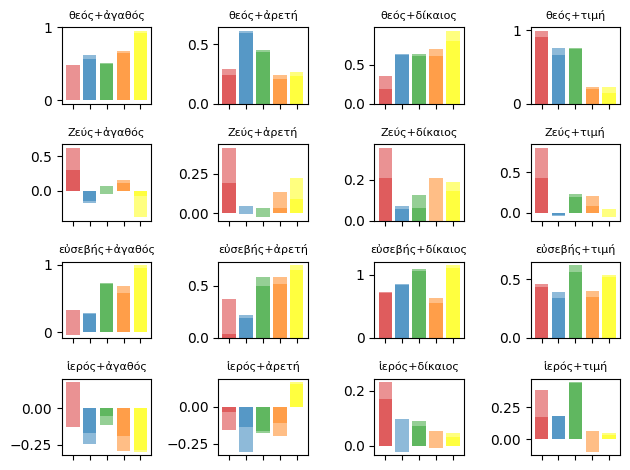

In [18]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

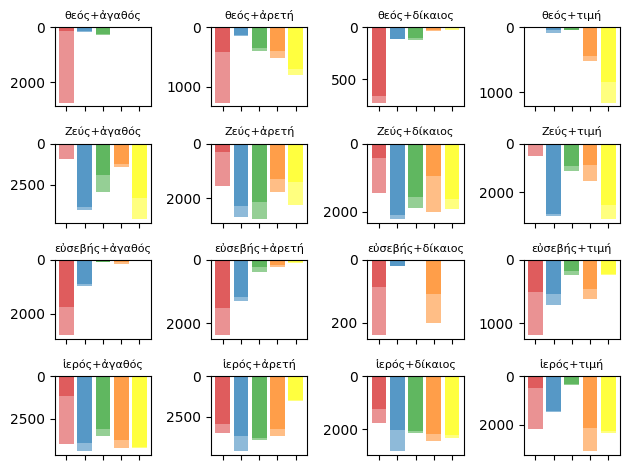

In [19]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            ordered = enumerate([tup[0] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            ordered = enumerate([tup[0] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed@_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])
        axs[worda[0], wordb[0]].invert_yaxis()


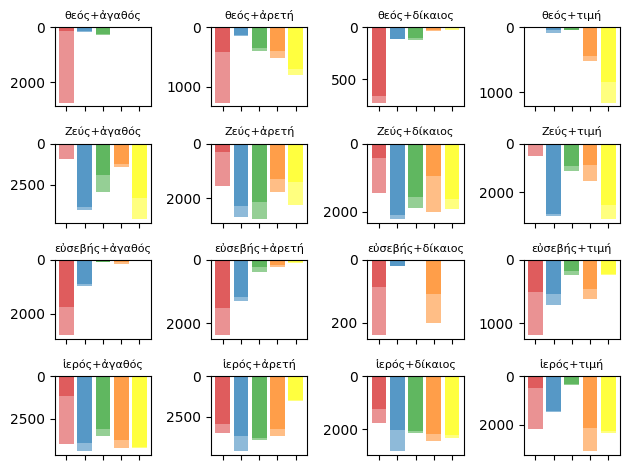

In [20]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            ordered = enumerate([tup[0] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            ordered = enumerate([tup[0] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed@_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])
        axs[worda[0], wordb[0]].invert_yaxis()

In [23]:
sub = "christian"
keyed_vectors = vectors_seed1_dict[sub]
vectors = keyed_vectors.vectors
words = keyed_vectors.index_to_key

In [27]:
keys=religion_final

In [28]:
keyed_vectors[religion_final]

array([[ 3.34955752e-01,  6.39415085e-01,  5.11020243e-01,
        -2.56405413e-01,  1.18183263e-01,  4.13276106e-02,
         5.39683938e-01, -7.38129854e-01,  1.77499712e-01,
        -6.32226408e-01,  3.03953707e-01, -5.27289510e-01,
         3.69753167e-02, -3.11075658e-01,  7.58028865e-01,
         1.11555524e-01, -4.95785624e-01,  7.34878778e-01,
        -6.16435170e-01, -6.92734778e-01,  4.17840600e-01,
         1.54080972e-01, -3.50268424e-01,  3.49389672e-01,
        -4.67331320e-01, -3.94818306e-01,  1.19769728e+00,
         2.12151632e-01,  8.47544909e-01,  5.78876615e-01,
         1.60716787e-01, -3.84354621e-01,  2.26518095e-01,
        -2.31523037e-01, -2.12793142e-01, -3.51527750e-01,
        -4.97637540e-01, -1.02054015e-01, -3.38651836e-01,
         4.90876883e-01,  1.73974186e-01, -1.52319700e-01,
         8.52494180e-01,  4.98685576e-02,  1.79556802e-01,
         5.09802401e-01, -2.51637757e-01, -5.81077218e-01,
        -4.96791869e-01, -2.56141603e-01,  4.52160567e-0

In [42]:
def get_tsne_coors(keyed_vectors, keys=None, perplexity=18, seed=1):
    if keys != None:
        vectors = keyed_vectors[keys]
        words = np.array(keys)
    else:
        vectors = keyed_vectors.vectors
        words = np.array(keyed_vectors.index_to_key)
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity, init="pca", learning_rate='auto', metric='cosine', n_iter=1000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(vectors) # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words

In [43]:
xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=30)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [53]:
def draw_special_words(wordlist, color, fontsize=6):
    color_idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    for x,y,w in zip(xs[color_idx], ys[color_idx] - 0.003, words[color_idx]):
        ax.text(x,y,w, horizontalalignment='center', fontsize=fontsize, color=color, zorder=3)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


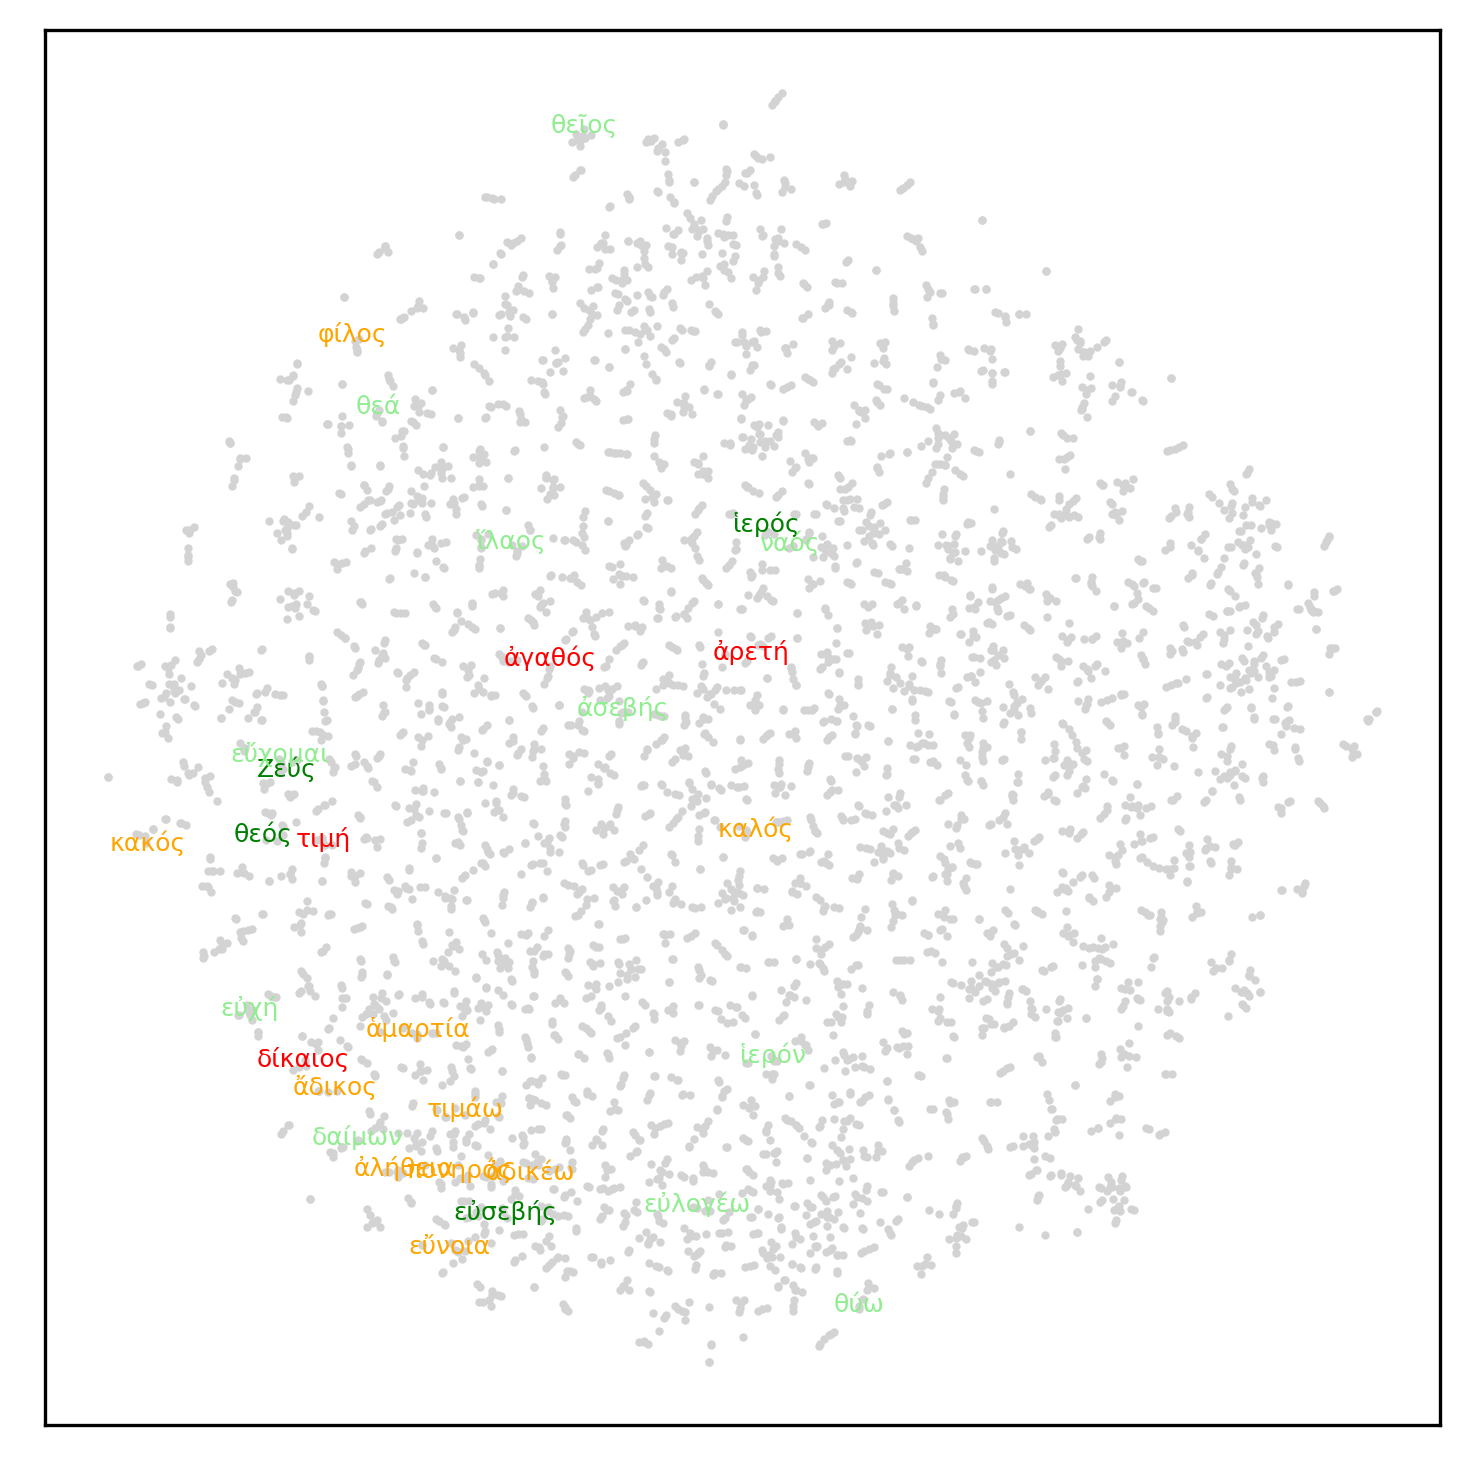

In [66]:
sub = "archaic"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)

keyed_vectors = vectors_seed1_dict[sub]

xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=5)

special_words = religion_final + morality_final + morality_extension
# all words as dots if not in lists
dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)

draw_special_words(religion_final, "green")
draw_special_words(morality_final, "red")
draw_special_words(morality_extension, "orange")
draw_special_words(religion_extension, "lightgreen")


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


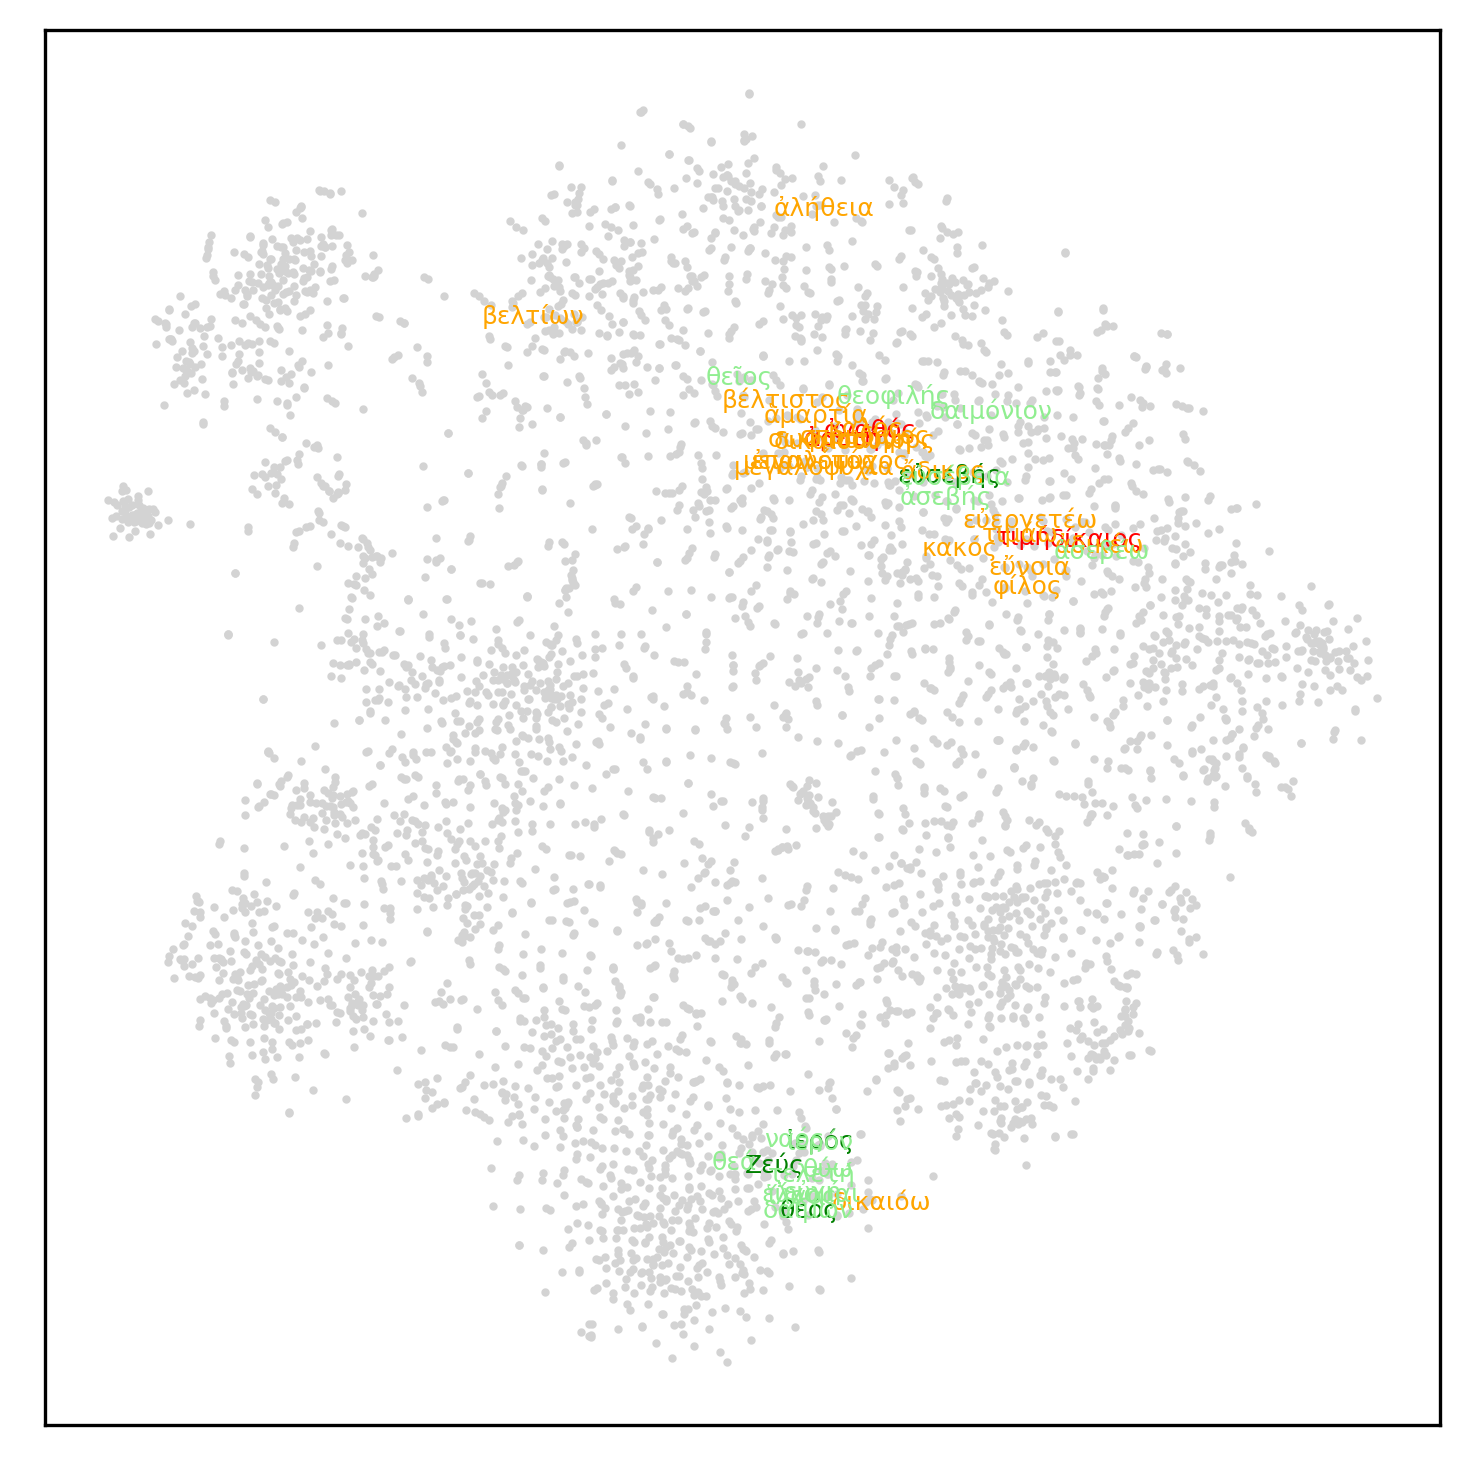

In [67]:
sub = "classical"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)

keyed_vectors = vectors_seed1_dict[sub]

xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=30)

special_words = religion_final + morality_final + morality_extension
# all words as dots if not in lists
dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)

draw_special_words(religion_final, "green")
draw_special_words(morality_final, "red")
draw_special_words(morality_extension, "orange")
draw_special_words(religion_extension, "lightgreen")

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


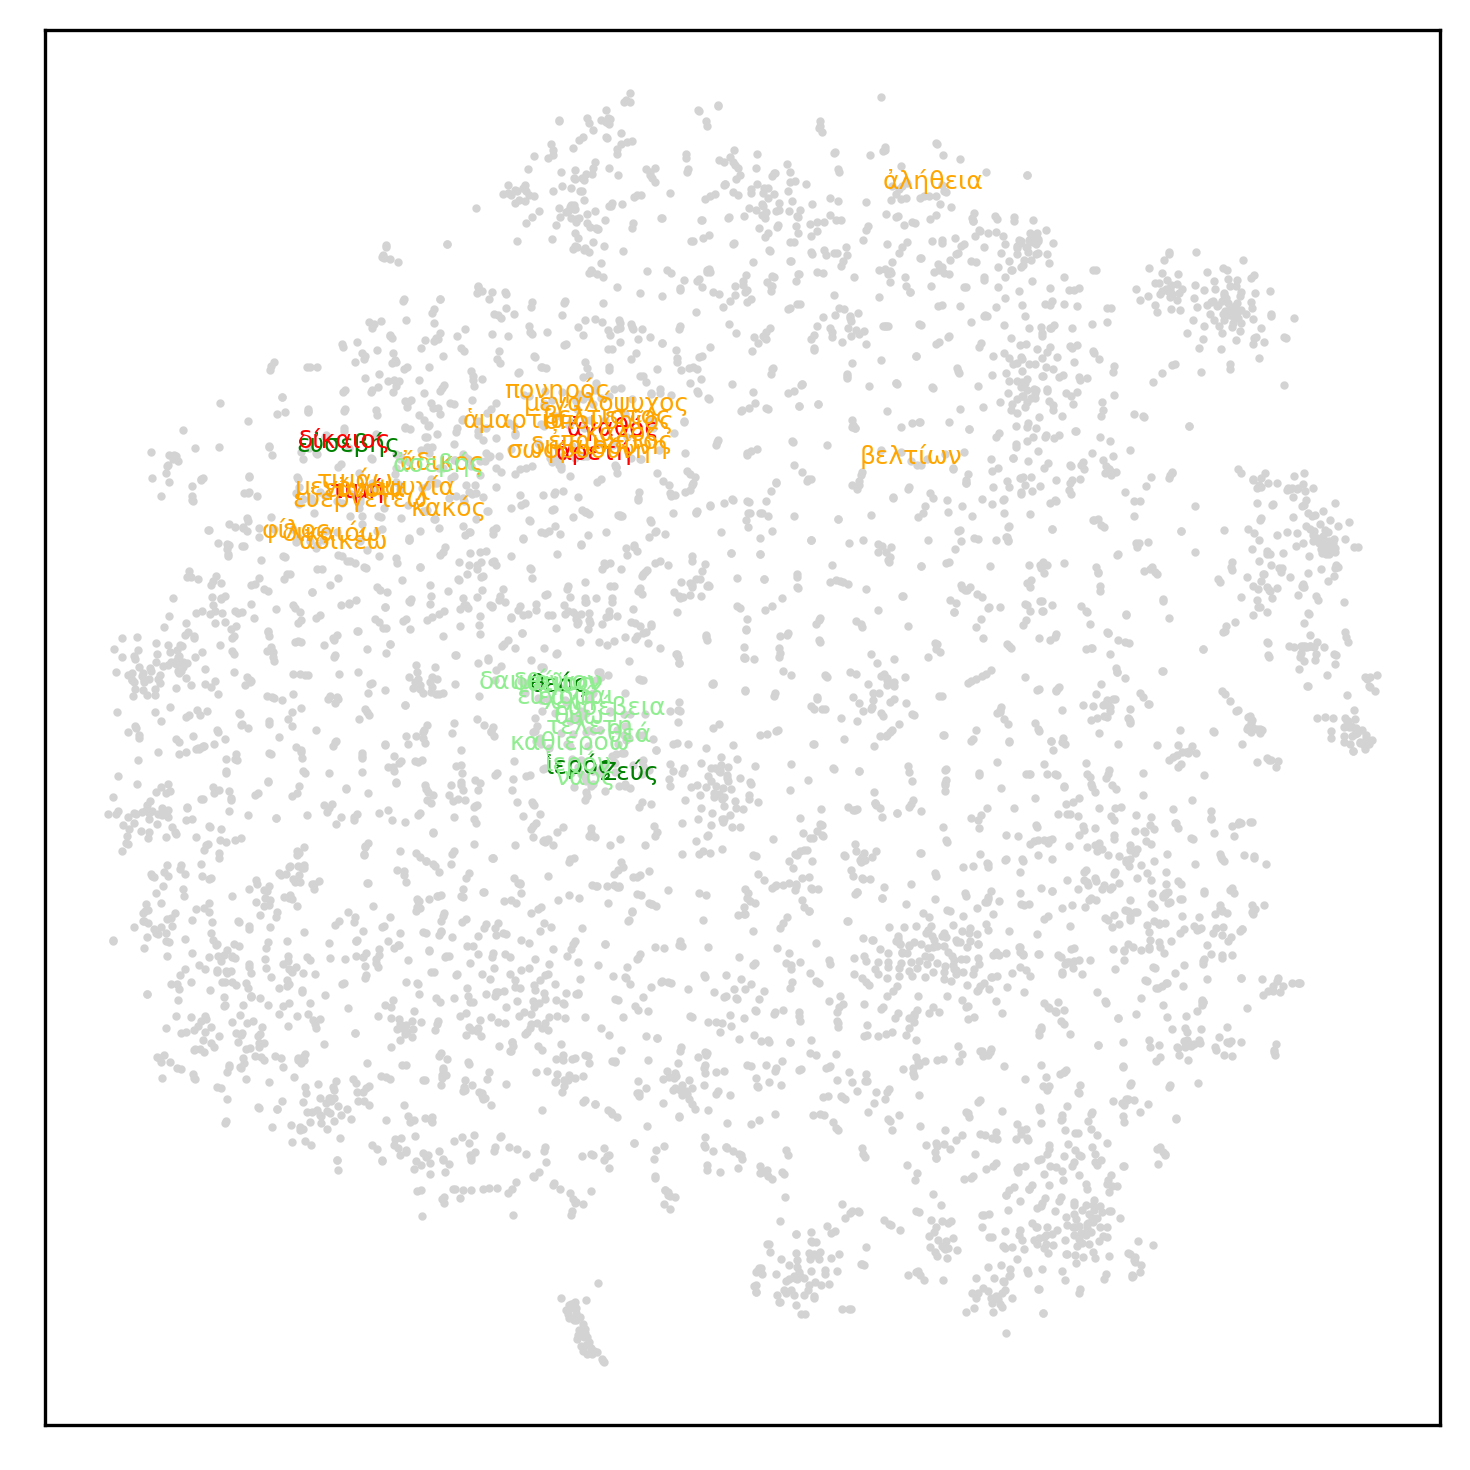

In [68]:
sub = "roman"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)

keyed_vectors = vectors_seed1_dict[sub]

xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=25)

special_words = religion_final + morality_final + morality_extension
# all words as dots if not in lists
dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)

draw_special_words(religion_final, "green")
draw_special_words(morality_final, "red")
draw_special_words(morality_extension, "orange")
draw_special_words(religion_extension, "lightgreen")



ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


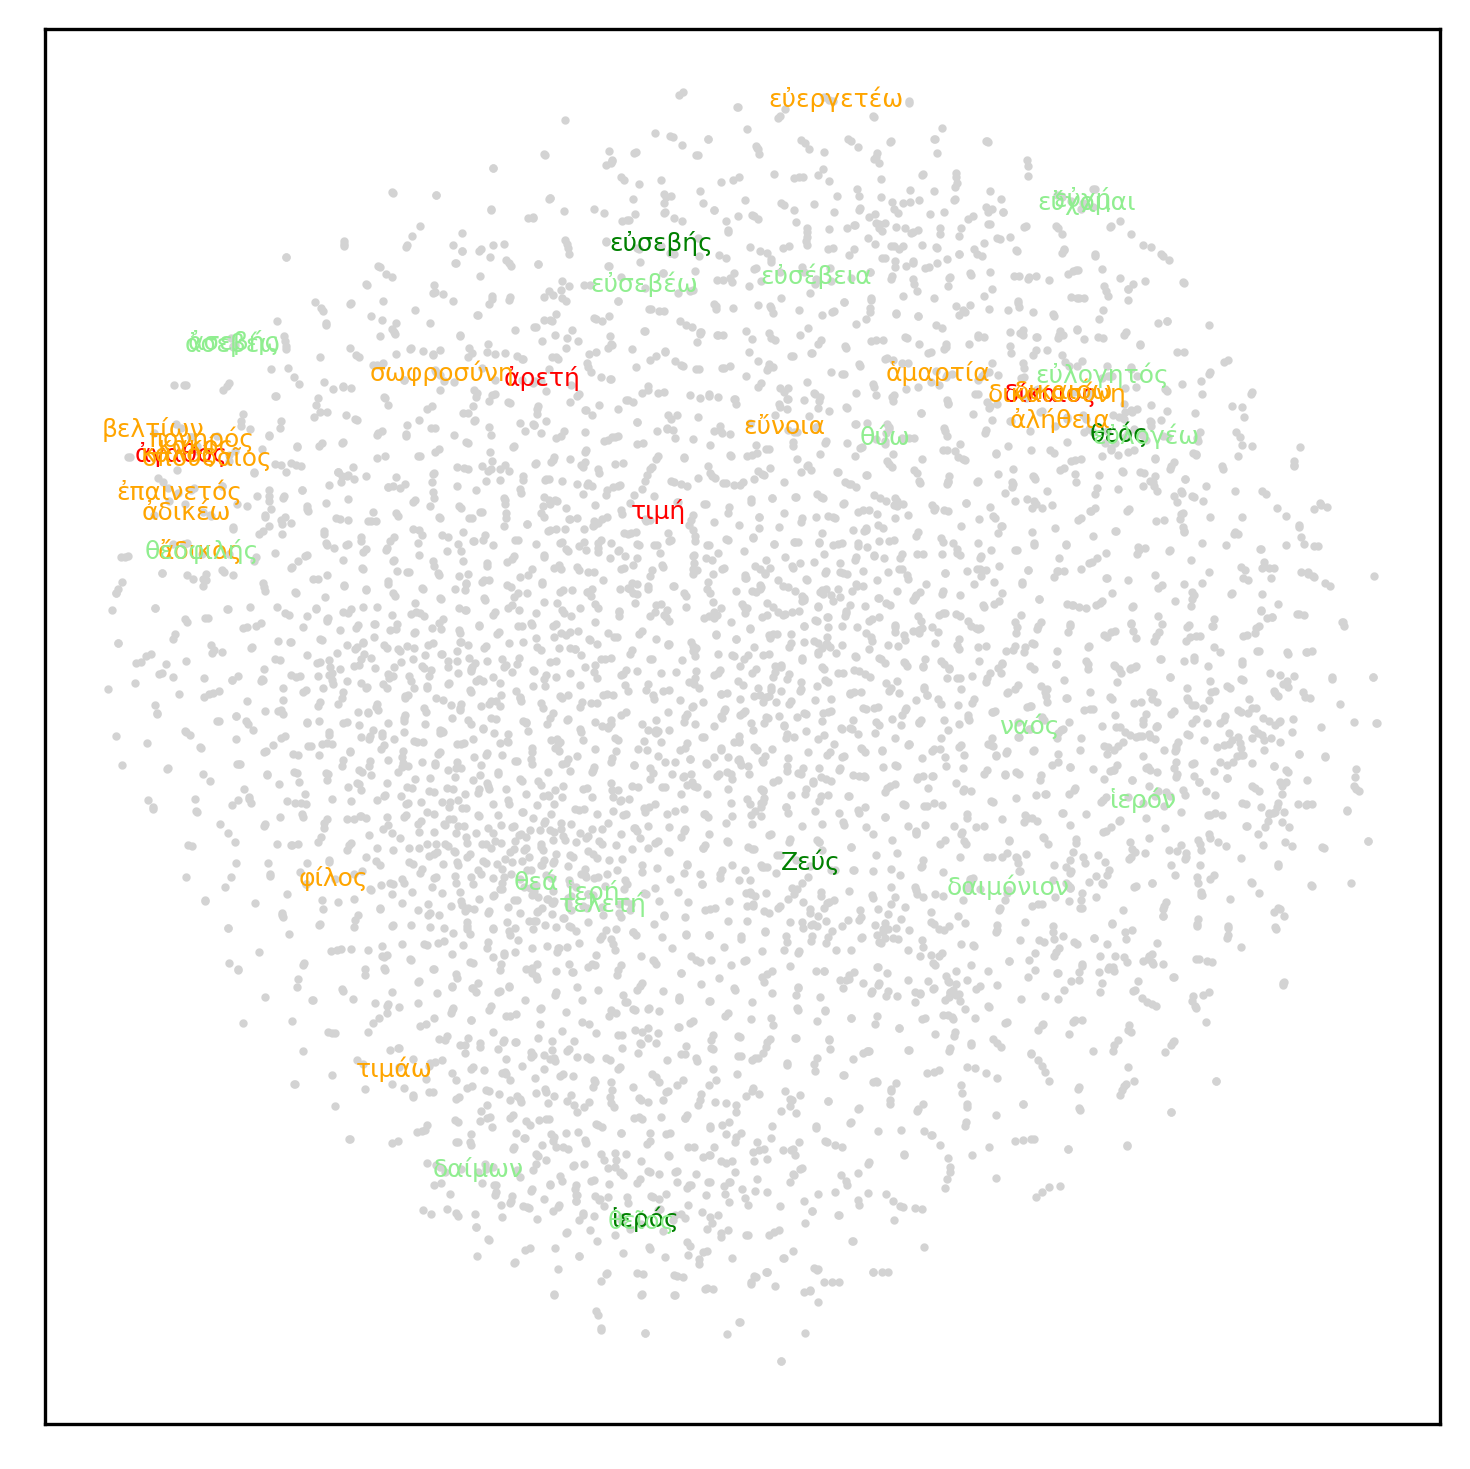

In [69]:
sub = "christian"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)

keyed_vectors = vectors_seed1_dict[sub]

xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=30)

special_words = religion_final + morality_final + morality_extension
# all words as dots if not in lists
dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)

draw_special_words(religion_final, "green")
draw_special_words(morality_final, "red")
draw_special_words(morality_extension, "orange")
draw_special_words(religion_extension, "lightgreen")


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


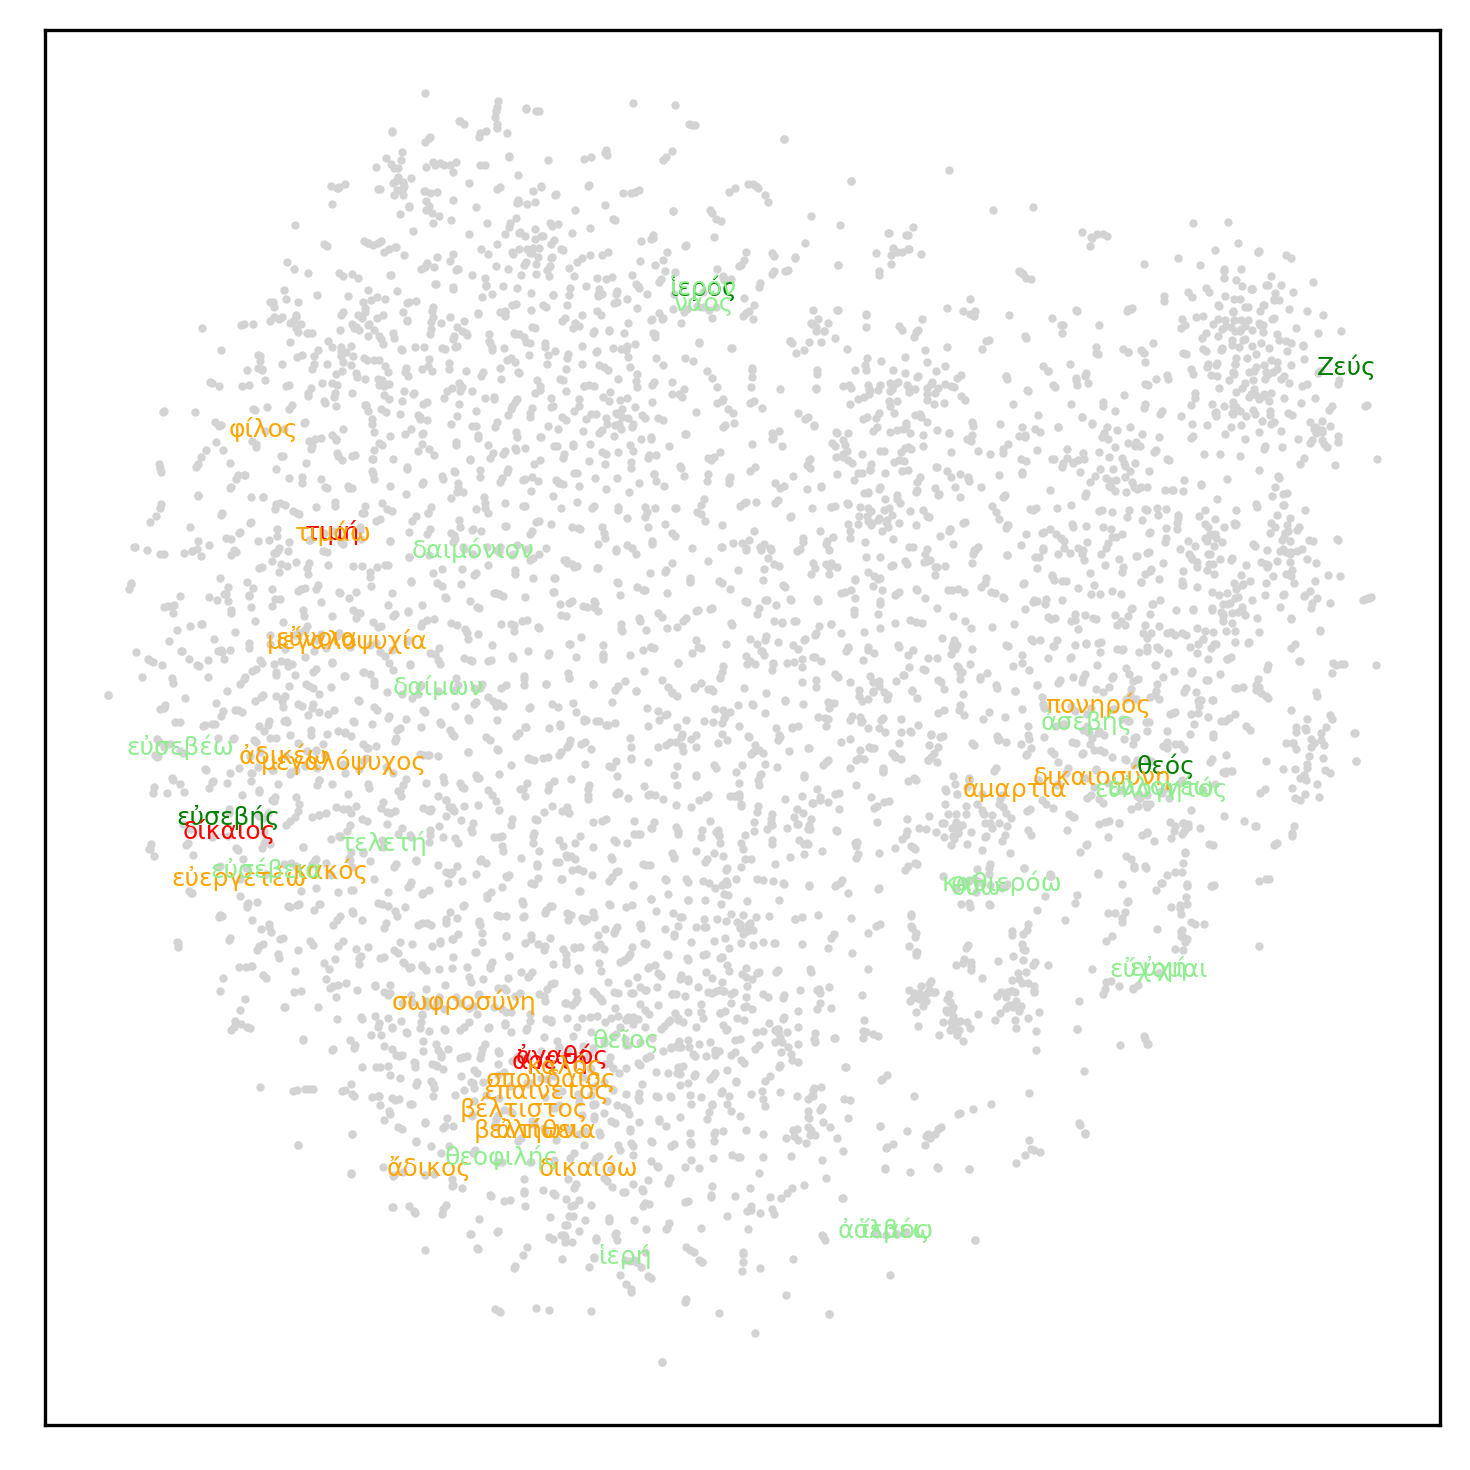

In [72]:
sub = "jewish"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)

keyed_vectors = vectors_seed1_dict[sub]

xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=25)

special_words = religion_final + morality_final + morality_extension
# all words as dots if not in lists
dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)

draw_special_words(religion_final, "green")
draw_special_words(morality_final, "red")
draw_special_words(morality_extension, "orange")
draw_special_words(religion_extension, "lightgreen")



ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)